In [2]:
import math
import pickle

import pandas as pd
import numpy as np
import os.path as op
import pylab as pl

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors

# 1. Load

In [3]:
major_class_df = pd.read_pickle('major_class_df.pickle')
minor_class_df = pd.read_pickle('minor_class_df.pickle')
novel_df = pd.read_pickle('novel_df.pickle')

major_class_df = major_class_df.drop(columns=['used_for_generation', 'molecular_fingerprint'])
minor_class_df = minor_class_df.drop(columns=['used_for_generation', 'molecular_fingerprint'])
novel_df = novel_df.drop(columns=['synthetic_accessibility_score', 'molecular_fingerprint'])

major_class_df.columns = ['SMILES_major']
minor_class_df.columns = ['SMILES_minor']
novel_df.columns = ['SMILES_generated']

print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)

Index(['SMILES_major'], dtype='object')
Index(['SMILES_minor'], dtype='object')
Index(['SMILES_generated'], dtype='object')


# 2. Sanitize

In [4]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [5]:
novel_df['mol'] = novel_df.SMILES_generated.apply(sanitize)
minor_class_df['mol'] = minor_class_df.SMILES_minor.apply(sanitize)
major_class_df['mol'] = major_class_df.SMILES_major.apply(sanitize)

Sanitization error: Explicit valence for atom # 23 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 15 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 17 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 6 C, 7, is greater than permitted
Sanitization error: Explicit valence for atom # 2 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 5 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 20 C, 5, is greater than permitted


In [6]:
print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)

print('BEFORE')

print(len(major_class_df))
print(len(minor_class_df))
print(len(novel_df))

major_class_df = major_class_df.dropna()
minor_class_df = minor_class_df.dropna()
novel_df = novel_df.dropna()

print('AFTER')

print(len(major_class_df))
print(len(minor_class_df))
print(len(novel_df))

Index(['SMILES_major', 'mol'], dtype='object')
Index(['SMILES_minor', 'mol'], dtype='object')
Index(['SMILES_generated', 'mol'], dtype='object')
BEFORE
285413
189940
5848
AFTER
285408
189936
5836


# 3. Unique scaffolds

In [7]:
unique_scaffolds_generated = set()
unique_scaffolds_minor = set()
unique_scaffolds_major = set()

In [8]:
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles

for index, row in novel_df.iterrows():
    try:
        unique_scaffolds_generated.add(MurckoScaffoldSmilesFromSmiles(row['SMILES_generated']))
    except Exception as e:
        print('novel_df', e)

for index, row in minor_class_df.iterrows():
    try:
        unique_scaffolds_minor.add(MurckoScaffoldSmilesFromSmiles(row['SMILES_minor']))
    except Exception as e:
        print('minor_class_df', e)
        
for index, row in major_class_df.iterrows():
    try:
        unique_scaffolds_major.add(MurckoScaffoldSmilesFromSmiles(row['SMILES_major']))
    except Exception as e:
        print('major_class_df', e)

novel_df Sanitization error: Explicit valence for atom # 16 N, 4, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 12 N, 4, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 15 N, 4, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 0 C, 6, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 8 C, 6, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 17 C, 6, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 17 C, 6, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 17 C, 6, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 4 O, 3, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 3 C, 5, is greater than permitted
novel_df Sanitization error: Explicit valence for atom # 16 C, 5, is greater than pe

In [9]:
print('unique_scaffolds_generated', len(unique_scaffolds_generated))
print('unique_scaffolds_minor', len(unique_scaffolds_minor))
print('unique_scaffolds_major', len(unique_scaffolds_major))

unique_scaffolds_generated 3946
unique_scaffolds_minor 58229
unique_scaffolds_major 76244


In [10]:
print('novel_df', len(novel_df))
print('minor_class_df', len(minor_class_df))
print('major_class_df', len(major_class_df))

novel_df 5848
minor_class_df 189940
major_class_df 285413


In [11]:
generated_minor_intersection = unique_scaffolds_minor.intersection(unique_scaffolds_generated)
generated_major_intersection = unique_scaffolds_major.intersection(unique_scaffolds_generated)

print('generated_minor_intersection', len(generated_minor_intersection))
print('generated_major_intersection', len(generated_major_intersection))

generated_minor_intersection 2558
generated_major_intersection 2180


In [12]:
print(len(generated_minor_intersection) / len(unique_scaffolds_generated) * 100, '%')
print(len(generated_major_intersection) / len(unique_scaffolds_generated) * 100, '%')

64.8251393816523 %
55.24581855043081 %


# 4. Molecular Descriptors Analysis

In [13]:
print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)

Index(['SMILES_major'], dtype='object')
Index(['SMILES_minor'], dtype='object')
Index(['SMILES_generated'], dtype='object')


## 4.1 Molecular weight

In [21]:
from rdkit.Chem.Descriptors import ExactMolWt

def get_mol_weight_from_smiles(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            return ExactMolWt(Chem.AddHs(m))
        except Exception as e:
            print('row', row, e)

In [22]:
%%time

major_class_df['molecular_weight'] = major_class_df.SMILES_major.apply(get_mol_weight_from_smiles)
minor_class_df['molecular_weight'] = minor_class_df.SMILES_minor.apply(get_mol_weight_from_smiles)
novel_df['molecular_weight'] = novel_df.SMILES_generated.apply(get_mol_weight_from_smiles)

## 4.2 logP

In [23]:
from rdkit.Chem.Crippen import MolLogP

def get_logp_from_smiles(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            return MolLogP(Chem.AddHs(m))
        except Exception as e:
            print('row', row, e)

In [24]:
%%time

major_class_df['logP'] = major_class_df.SMILES_major.apply(get_logp_from_smiles)
minor_class_df['logP'] = minor_class_df.SMILES_minor.apply(get_logp_from_smiles)
novel_df['logP'] = novel_df.SMILES_generated.apply(get_logp_from_smiles)

## 4.3 TPSA

In [25]:
from rdkit.Chem.rdMolDescriptors import CalcTPSA

def get_tpsa_from_smiles(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            return CalcTPSA(Chem.AddHs(m))
        except Exception as e:
            print('row', row, e)

In [26]:
%%time

major_class_df['TPSA'] = major_class_df.SMILES_major.apply(get_tpsa_from_smiles)
minor_class_df['TPSA'] = minor_class_df.SMILES_minor.apply(get_tpsa_from_smiles)
novel_df['TPSA'] = novel_df.SMILES_generated.apply(get_tpsa_from_smiles)

CPU times: user 2min 29s, sys: 60 ms, total: 2min 29s
Wall time: 2min 28s


## 4.4 Synthetic Accessibility

In [7]:
_fscores = None

def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    _fscores = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in _fscores:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict
    
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro

In [8]:
def calculateScore(smiles_string):
    if _fscores is None:
        readFragmentScores()
    
    m = Chem.MolFromSmiles(smiles_string)
    if not m:
        return None
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m, 2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore

In [9]:
%%time

major_class_df['synthetic_accessibility_score'] = major_class_df.SMILES_major.apply(calculateScore)
minor_class_df['synthetic_accessibility_score'] = minor_class_df.SMILES_minor.apply(calculateScore)
novel_df['synthetic_accessibility_score'] = novel_df.SMILES_generated.apply(calculateScore)

CPU times: user 8min 19s, sys: 224 ms, total: 8min 19s
Wall time: 8min 18s


Text(0, 0.5, 'Probability density')

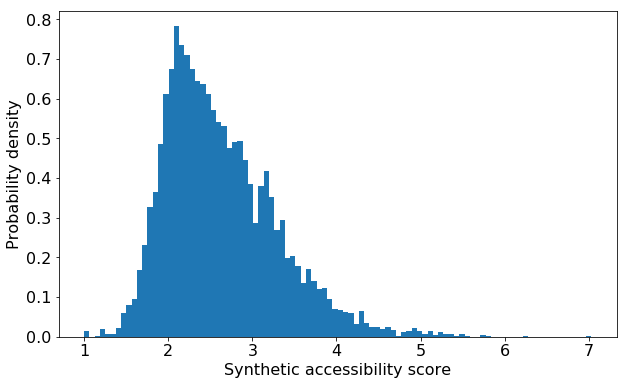

In [14]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
novel_df.synthetic_accessibility_score.hist(
    bins=48, 
    align='mid',
    density=True, 
    grid=False)
# pl.title("Histogram of synthetic accessibility")
pl.xlabel("Synthetic accessibility score")
pl.ylabel("Probability density")

In [12]:
novel_df.synthetic_accessibility_score.describe()

count    5836.000000
mean        2.629134
std         0.669090
min         1.000000
25%         2.131316
50%         2.506273
75%         3.017013
max         7.028683
Name: synthetic_accessibility_score, dtype: float64

In [13]:
novel_df.synthetic_accessibility_score.median()

2.506272855358497

In [19]:
print(len(novel_df[(novel_df.synthetic_accessibility_score > 6.5)]) / len(novel_df) * 100)

0.017135023989033587


In [20]:
print(len(novel_df[(novel_df.synthetic_accessibility_score > 6.5)]))

1


# Save results

In [27]:
%%time

major_class_df.to_pickle('backups/major_class_df.pickle')
minor_class_df.to_pickle('backups/minor_class_df.pickle')
novel_df.to_pickle('backups/novel_df.pickle')

CPU times: user 22.1 s, sys: 484 ms, total: 22.6 s
Wall time: 22.8 s


# Load results

In [ ]:
%%time

major_class_df.read_pickle('backups/major_class_df.pickle')
minor_class_df.read_pickle('backups/minor_class_df.pickle')
novel_df.read_pickle('backups/novel_df.pickle')

# Plot results

(1, 5.3)

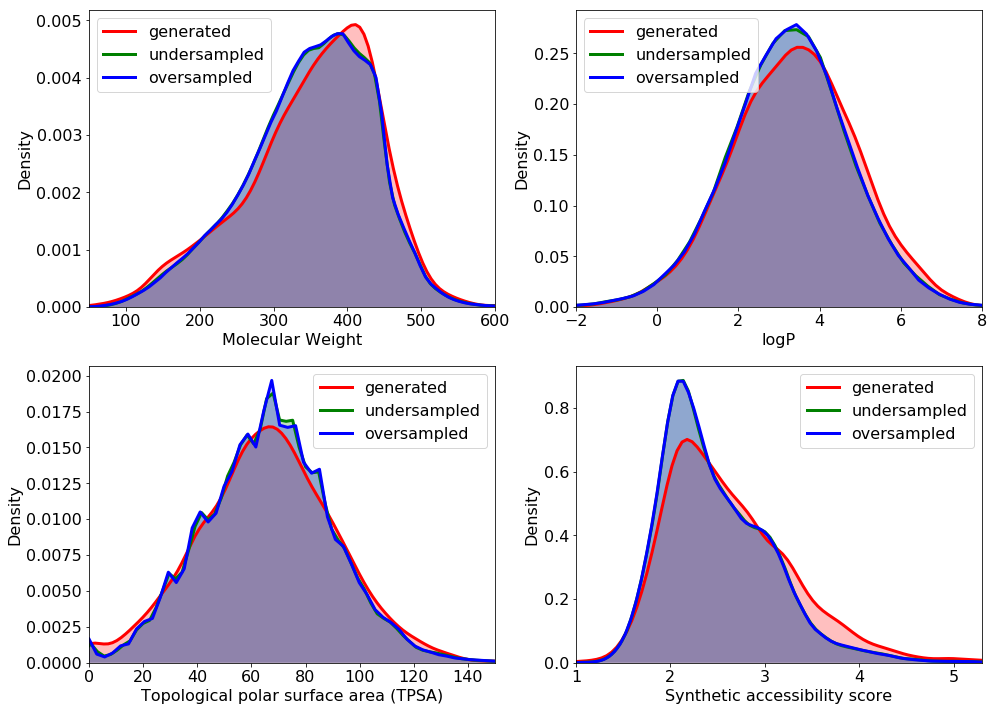

In [33]:
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(nrows=2, ncols=2, figsize=(16,12))

sns.distplot(novel_df.molecular_weight, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, color='red', label="generated", ax=ax[0,0])
sns.distplot(minor_class_df.molecular_weight, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="undersampled", color='green', ax=ax[0,0])
sns.distplot(major_class_df.molecular_weight, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="oversampled", color='blue', ax=ax[0,0])
ax[0,0].set(xlabel='Molecular Weight', ylabel='Density')
ax[0,0].set_xlim(50,600)

sns.distplot(novel_df.logP, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, color='red', label="generated", ax=ax[0,1])
sns.distplot(minor_class_df.logP, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="undersampled", color='green', ax=ax[0,1])
sns.distplot(major_class_df.logP, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="oversampled", color='blue', ax=ax[0,1])
ax[0,1].set(xlabel='logP', ylabel='Density')
ax[0,1].set_xlim(-2, 8)

sns.distplot(novel_df.TPSA, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, color='red', label="generated", ax=ax[1,0])
sns.distplot(minor_class_df.TPSA, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="undersampled", color='green', ax=ax[1,0])
sns.distplot(major_class_df.TPSA, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="oversampled", color='blue', ax=ax[1,0])
ax[1,0].set(xlabel='Topological polar surface area (TPSA)', ylabel='Density')
ax[1,0].set_xlim(0, 150)

sns.distplot(novel_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, color='red', label="generated", ax=ax[1,1])
sns.distplot(minor_class_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="undersampled", color='green', ax=ax[1,1])
sns.distplot(major_class_df.synthetic_accessibility_score, hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="oversampled", color='blue', ax=ax[1,1])
ax[1,1].set(xlabel='Synthetic accessibility score', ylabel='Density')
ax[1,1].set_xlim(1, 5.3)